Notes: 
- Ranking the probability of patient's fall (e.g. high risk, etc.) might be enough instead of assigning individual patient's fall/non-fall value.
- Missing nursing data is not MCAR -> dummy variables for unknown values might be a good predictors

In [1]:
# Installations

# %pip install autoviz
# %pip install miceforest
# %pip install prince
# %pip install gower
# %pip install shap
# %pip install imblearn

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import shap
import prince
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay





%matplotlib inline


# PATIENT FALL RISK ASSESSMENT PROJECT

## Background


The clinic's director seeks to improve patient safety and reduce fall-related incidents. Falls among patients pose a significant risk, leading to severe health complications and increased healthcare costs. To address this issue, a data-driven assessment is required to better understand the factors contributing to falls and to develop predictive measures for mitigating them effectively.

The dataset used for this analysis consists of patient-related information, categorized into two types:

 - Medical Data: Collected upon patient admission and during patient stay, this dataset includes age, gender, diagnosis, and procedure. This data is always available for every patient.

 - Nursing Data: The remaining variables in this dataset come from the so-called fall risk assessment. This assessment is conducted by nurses and contains various risk factors that are assumed to contribute to patient falls. Unlike medical data, nursing data is manually recorded and is only collected for specific patients—namely, those deemed at an increased risk of falling or those who exceed a certain age threshold. From these variables also the variable fall risk is derived, that is the traditional nursing assessment of a patient’s fall risk.

Our task is to conduct a predictive analytics project with two main objectives:

1) Develop a reliable assessment of the risk of patient falls based on historical data.

2) Identify key factors that contribute to fall incidents.

## Section 1: Data Overview and Preparation

In this section, we:
 - Provide a clear and intuitive summary of the dataset.

 - Define an approach to identify outliers and implement an appropriate method to handle them.

 - Identify and assess missing data. Define an approach to handle the missing data.

 - Establish an appropriate strategy for partitioning training and testing datasets


### 1. SUMMARY OF THE DATASET

In [3]:
# Load the dataset
path = "../data/kip_sdm_syn.csv"
df = pd.read_csv(path)

# Display the first few rows to understand the structure
df.head()

,fallen,id,age,procedure,diagnosis,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-impairment,bed_mobility-jones,bed_mobility-skin_condition,transfer-impairment,transfer,medical_items,medical_items-arm_or_leg_splint,medical_items-A_V_system,medical_items-plaster_or_neck_brace,medical_items-compression_stocking,medical_items-ventilation_mask,medical_items-O2_glasses,medical_items-orthesis,medical_items-prosthesis,medical_items-skin_condition_at_item_application,fall-last_12_month,fall-how_many_last_12_month,fall-while_stay,fall-while_transfer,walk-impairment,walk-jones,walk-balance_and_gait_impaired,walking_aid,excretions-impairment,excretions-incontinence,excretions-nykturie,cognition-impairment,cognition-disoriented_time,cognition-disoriented_location,cognition-disoriented_own_person,cognition-agitated,cognition-confused,psychotropic_or_sedatives_drugs,decubitus-risk,fall-risk,diseases,sex
0,False,179020,39,0,S250,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,2,False,False,False,False,False,NaN,False,False,False,False,False,False,NaN,NaN,False,female
1,False,112009,29,0,M418,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male
2,False,54403,29,9-26,S910,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,False,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,NaN,NaN,0,NaN,female
3,False,13054,64,8-77,M400,True,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,False,False,NaN,False,False,True,True,False,NaN,False,False,False,False,False,False,0,0,False,male
4,False,45770,89,8-93,K630,False,NaN,False,NaN,NaN,NaN,NaN,2,NaN,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,False,False,NaN,False,False,False,False,False,False,NaN,NaN,NaN,male


#### Identify Target and 'id'

In [4]:
# 'fallen' is the target: "Ist der Patient gestürzt?" (logical => True/False).
# 'id' is just an identifier, so typically we don't use it for modeling.

if "id" in df.columns:
    # Keep 'id' in the dataframe for reference if needed, but do not model with it
    pass
	# df.drop(columns=["id"], inplace=True)

if "fallen" not in df.columns:
    raise ValueError("Target column 'fallen' not found in dataset. Please verify.")

#### Shape and Data Types

In [5]:
print("Number of rows and columns:", df.shape)
print("\nData Types:\n", df.dtypes.value_counts())
print("\nColumn Names:\n", df.columns.tolist())

Number of rows and columns: (40000, 45)

Data Types:
 object     23
bool       19
int64       2
float64     1
Name: count, dtype: int64

Column Names:
 ['fallen', 'id', 'age', 'procedure', 'diagnosis', 'c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-jones', 'bed_mobility-skin_condition', 'transfer-impairment', 'transfer', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-how_many_last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-jones', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disorie

In [6]:
# List all variable names and their data types
print("\nVariable names and their data types:")
print(df.dtypes)  # Displays column names with their data types


Variable names and their data types:
fallen                                                 bool
id                                                    int64
age                                                   int64
procedure                                            object
diagnosis                                            object
c_zriserh1                                             bool
decubitus-admission                                  object
decubitus-at_the_moment                              object
bed_mobility-impairment                              object
bed_mobility-jones                                   object
bed_mobility-skin_condition                          object
transfer-impairment                                  object
transfer                                             object
medical_items                                        object
medical_items-arm_or_leg_splint                        bool
medical_items-A_V_system                               bool
me

#### Distribution of the Target Variable `fallen`

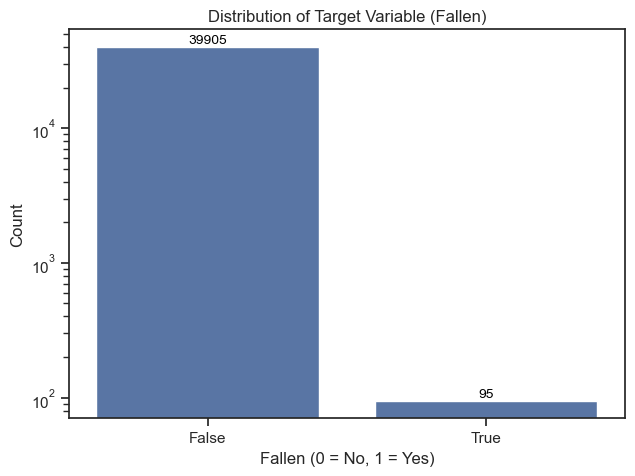

In [7]:
sns.countplot(data=df, x='fallen')
plt.title('Distribution of Target Variable (Fallen)')
plt.xlabel('Fallen (0 = No, 1 = Yes)')
plt.ylabel('Count')

# Annotate the bars with their respective counts
for p in plt.gca().patches:
	count = int(p.get_height())
	plt.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
				 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
				 textcoords='offset points')

plt.yscale('log')  # Use logarithmic scale for better visualization
plt.show()

In [8]:
print("Value distribution for 'fallen':")
print(df['fallen'].value_counts())
fall_counts = df['fallen'].value_counts(normalize=True) * 100
print("\nPercentage of Fall Incidents:\n", fall_counts.round(2))

Value distribution for 'fallen':
fallen
False    39905
True        95
Name: count, dtype: int64

Percentage of Fall Incidents:
 fallen
False    99.76
True      0.24
Name: proportion, dtype: float64


#### CHECK MISSING VALUES

In [9]:
# Calculate missing values and percentages for all columns
missing = df.isnull().sum()
missing_percentage = (missing / len(df)) * 100

# Create a DataFrame for the summary
missing_summary = pd.DataFrame({
	'Missing Values': missing,
	'Percentage': missing_percentage.round(2)
}).sort_values(by='Percentage', ascending=False)

# Display the summary
print("\nMissing Values per Column:\n", missing_summary)


Missing Values per Column:
                                                   Missing Values  Percentage
medical_items-skin_condition_at_item_application       38637         96.59  
fall-how_many_last_12_month                            38600         96.50  
bed_mobility-skin_condition                            38447         96.12  
bed_mobility-jones                                     37593         93.98  
fall-while_stay                                        37212         93.03  
transfer                                               36994         92.48  
walk-jones                                             35627         89.07  
decubitus-admission                                    30601         76.50  
decubitus-at_the_moment                                30401         76.00  
psychotropic_or_sedatives_drugs                        30203         75.51  
diseases                                               29956         74.89  
cognition-impairment                           

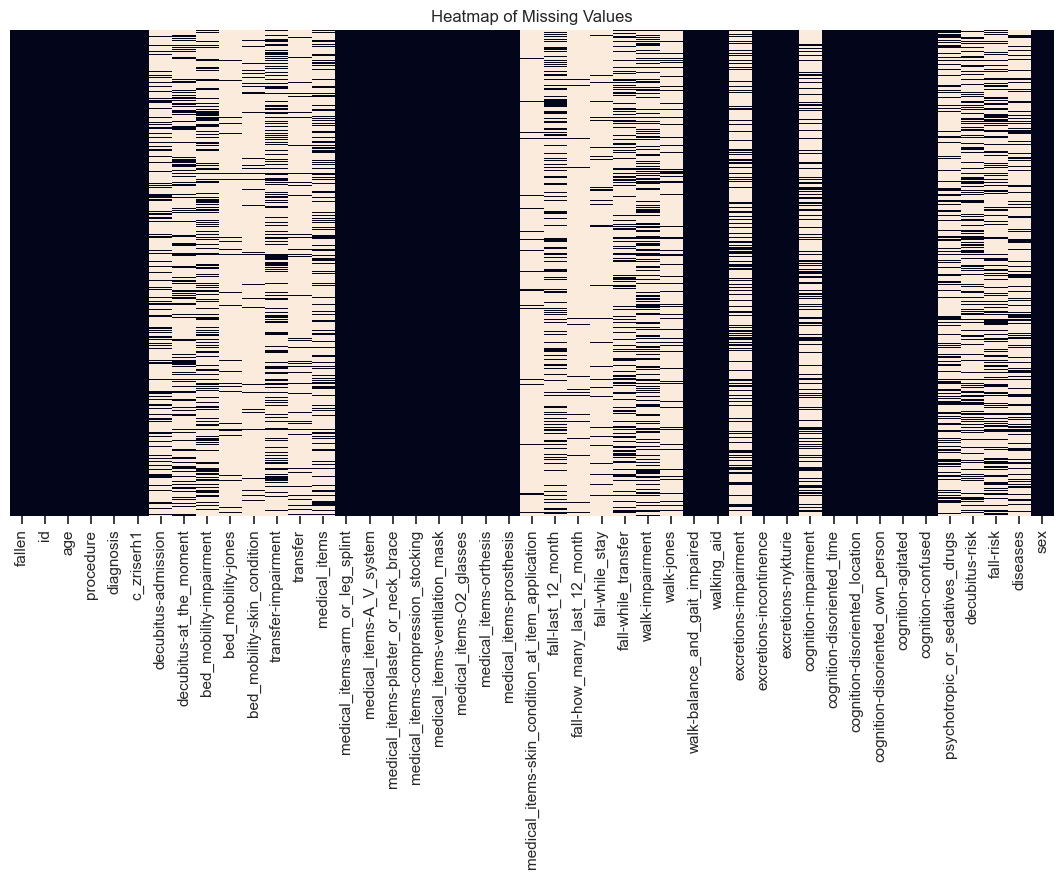

In [10]:
# Visualizing missing data
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

Description: MAR, no obvious pattern to see

#### Transform and Categorize Variables

From the provided explanations, we have the following columns to consider:
  - Columns with 0 missing values (fully recorded).
  - Logical columns with high missingness => means "not assessed" or "unknown".
  - Jones score columns (character) that might hold numeric or ordinal values.
  - 'decubitus-risk' and 'fall-risk' (character) with values {0, +, ++}
  - `sex` with values {male, female}
  - 'c_zriserh1' is undocumented => decide whether to keep or drop.

##### Mapping `decubitus-risk` and `fall-risk`

In [11]:
# Convert 'decubitus-risk' and 'fall-risk' from {0, +, ++} to ordinal numeric
#     For example: 0 -> 0, + -> 1, ++ -> 2. If these are truly ordinal risk levels,
#     it helps to store them numerically.
risk_mapping = {"0": 0, "+": 1, "++": 2}

if "decubitus-risk" in df.columns:
    df["decubitus-risk"] = df["decubitus-risk"].map(risk_mapping).astype("Int64") # TODO: Transfer to categorical

if "fall-risk" in df.columns:
    df["fall-risk"] = df["fall-risk"].map(risk_mapping).astype("Int64") # TODO: Transfer to categorical

In [12]:
print("Unique values and their counts for 'decubitus-risk':")
print(df['decubitus-risk'].value_counts(dropna=False))

Unique values and their counts for 'decubitus-risk':
decubitus-risk
<NA>    28511
0        8686
1        2193
2         610
Name: count, dtype: Int64


In [13]:
print("Unique values and their counts for 'fall-risk':")
print(df['fall-risk'].value_counts(dropna=False))

Unique values and their counts for 'fall-risk':
fall-risk
<NA>    27672
0        8446
1        3685
2         197
Name: count, dtype: Int64


##### Mapping `sex`

In [14]:
# Convert 'sex' to binary values and handle missing values
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

In [15]:
print("Unique values and their counts for 'sex':")
print(df['sex'].value_counts(dropna=False))

Unique values and their counts for 'sex':
sex
1    21371
0    18629
Name: count, dtype: int64


##### Categorize Numerical Variables

In [16]:
# # Automatically select numerical variables
# Exclude 'id' from numerical_vars

numerical_vars = df.select_dtypes(include=['int64', 'float64']).columns.difference(['id', 'sex'])
print("Numerical variables (excluding 'id'):", numerical_vars.tolist())

Numerical variables (excluding 'id'): ['age', 'decubitus-risk', 'fall-how_many_last_12_month', 'fall-risk']


##### Inspect statistics for numerical variables

In [17]:
print("Statistics for numerical variables:")
numerical_stats = df[numerical_vars].describe().T  # Transpose for better readability
numerical_stats["variance"] = df[numerical_vars].var()  # Add variance column
print(numerical_stats)

Statistics for numerical variables:
                             count      mean      std      min   25%   50%   \
age                          40000.0     57.66  19.124127  19.0  39.0  59.0   
decubitus-risk               11489.0  0.297067   0.561279   0.0   0.0   0.0   
fall-how_many_last_12_month   1400.0  1.754659    1.54334   1.0   1.0   1.0   
fall-risk                    12328.0  0.330873   0.503365   0.0   0.0   0.0   

                             75%   max     variance   
age                          74.0  104.0  365.732243  
decubitus-risk                0.0    2.0    0.315034  
fall-how_many_last_12_month   1.0    5.0    2.381899  
fall-risk                     1.0    2.0    0.253376  


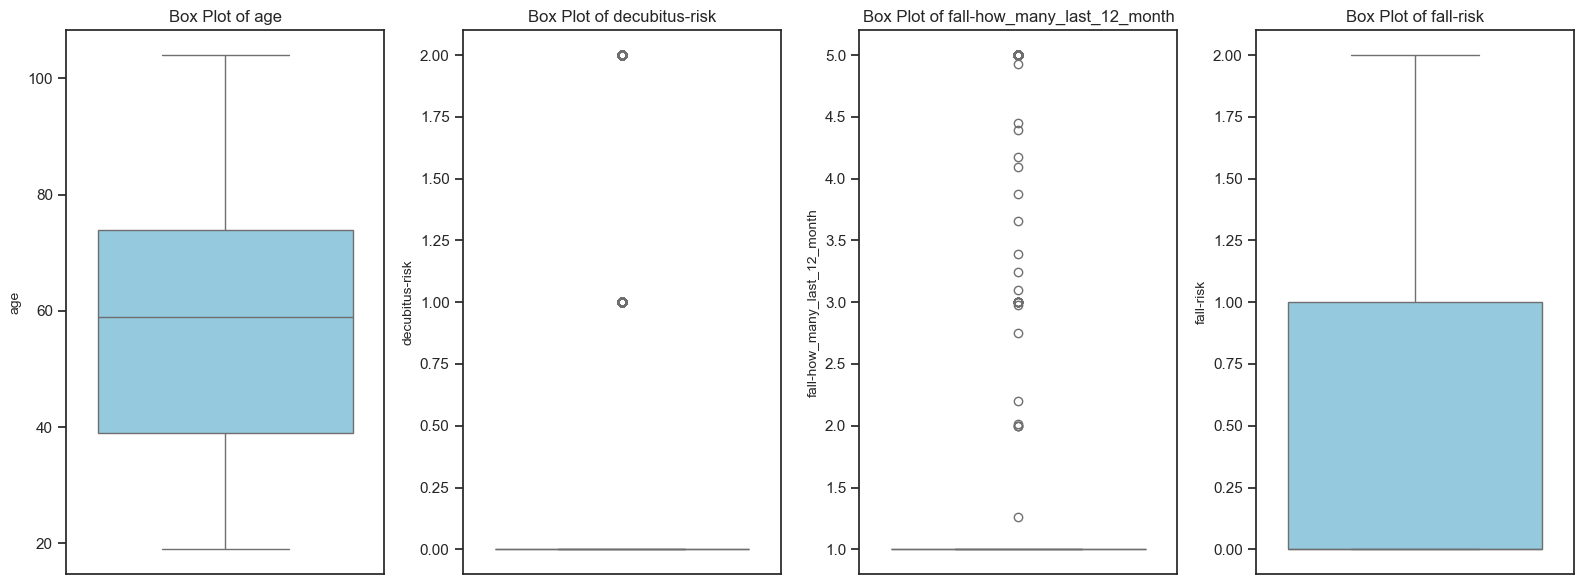

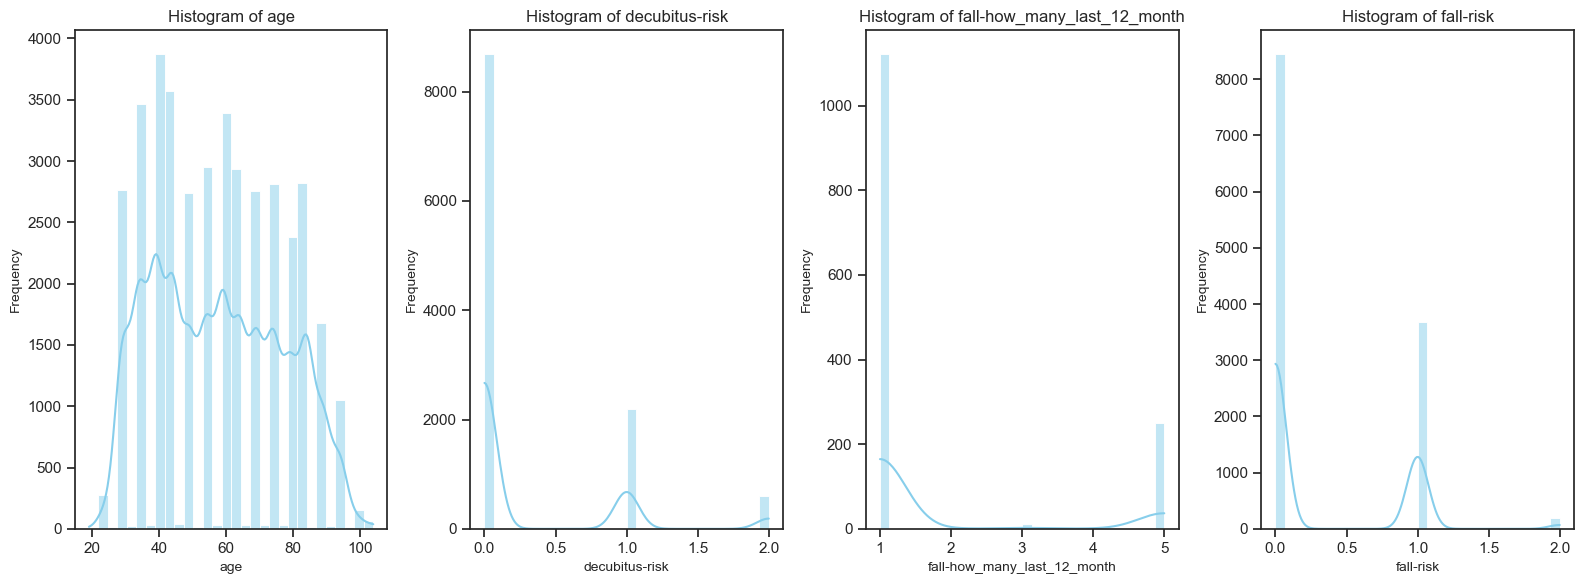

In [18]:
# Create side-by-side box plots for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.boxplot(y=df[col], color='skyblue')  # Use a consistent color for all plots
	plt.title(f'Box Plot of {col}', fontsize=12)  # Add title
	plt.ylabel(col, fontsize=10)  # Add y-axis label
	plt.xlabel('')  # Remove x-axis label for cleaner look
	plt.xticks([])  # Remove x-axis ticks for cleaner look

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Create histograms for numerical variables
plt.figure(figsize=(16, 6))  # Adjust the figure size for better visualization

# Loop through numerical variables and create subplots
for i, col in enumerate(numerical_vars):
	plt.subplot(1, len(numerical_vars), i + 1)  # Create subplots in a single row
	sns.histplot(df[col], kde=True, color='skyblue', bins=30)  # Histogram with KDE overlay
	plt.title(f'Histogram of {col}', fontsize=12)  # Add title
	plt.xlabel(col, fontsize=10)  # Add x-axis label
	plt.ylabel('Frequency', fontsize=10)  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

##### Categorize Categorical/Bool Variables

Upon examination, some features are recognized automatically as `object`.
We did further inspection to determine if the data types are properly assigned.
We determined the features that should be encoded as `bool` and convert them accoringly.

In [19]:
bool_vars = [
    "c_zriserh1",
    "decubitus-admission",
    "decubitus-at_the_moment",
    "bed_mobility-impairment",
    "bed_mobility-skin_condition",
    "transfer-impairment",
    "medical_items",
    "medical_items-skin_condition_at_item_application",
    "fall-last_12_month",
    "fall-while_stay",
    "fall-while_transfer",
    "walk-impairment",
    "excretions-impairment",
    "cognition-impairment",
    "psychotropic_or_sedatives_drugs",
    "diseases",
]

df[bool_vars] = df[bool_vars].astype("boolean")
# df.dtypes

##### Check for Correct Categorization

In [20]:
# Initialize empty lists for each category
target = 'fallen'
numerical_vars = ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']
categorical_vars = ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
ordinal_vars = []
bool_vars = ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location', 'cognition-disoriented_own_person', 'cognition-agitated', 'cognition-confused', 'psychotropic_or_sedatives_drugs', 'diseases']
id_vars = ['id']

# Print categorized variables
print("Numerical variables:", numerical_vars)
print("Categorical variables:", categorical_vars)
print("Ordinal variables:", ordinal_vars)
print("Boolean variables:", bool_vars)
print("ID variables:", id_vars)

# Check if all columns are categorized and there are no duplicates
all_categorized_columns = set(numerical_vars + categorical_vars + ordinal_vars + bool_vars + id_vars)
all_columns = set(df.columns)

# Find missing columns
missing_columns = all_columns - all_categorized_columns
if missing_columns:
	print("\nMissing columns that are not categorized:", missing_columns)
else:
	print("\nAll columns are categorized.")

# Find duplicate columns
duplicate_columns = [col for col in all_categorized_columns if list(all_categorized_columns).count(col) > 1]
if duplicate_columns:
	print("\nDuplicate columns found in categories:", duplicate_columns)
else:
	print("\nNo duplicate columns in categories.")

print(f'\n\nNumber of columns: {len(numerical_vars) + len(categorical_vars) + len(ordinal_vars) + len(bool_vars) + len(id_vars) + 1}')

Numerical variables: ['age', 'fall-how_many_last_12_month', 'decubitus-risk', 'fall-risk']
Categorical variables: ['procedure', 'diagnosis', 'bed_mobility-jones', 'transfer', 'walk-jones', 'sex']
Ordinal variables: []
Boolean variables: ['c_zriserh1', 'decubitus-admission', 'decubitus-at_the_moment', 'bed_mobility-impairment', 'bed_mobility-skin_condition', 'transfer-impairment', 'medical_items', 'medical_items-arm_or_leg_splint', 'medical_items-A_V_system', 'medical_items-plaster_or_neck_brace', 'medical_items-compression_stocking', 'medical_items-ventilation_mask', 'medical_items-O2_glasses', 'medical_items-orthesis', 'medical_items-prosthesis', 'medical_items-skin_condition_at_item_application', 'fall-last_12_month', 'fall-while_stay', 'fall-while_transfer', 'walk-impairment', 'walk-balance_and_gait_impaired', 'walking_aid', 'excretions-impairment', 'excretions-incontinence', 'excretions-nykturie', 'cognition-impairment', 'cognition-disoriented_time', 'cognition-disoriented_location

### 2. HANDLING MISSING VALUES

#### HANDLING MISSING NUMERICAL VARIABLES THROUGH SINGLE IMPUTATION


##### 🧾 Imputation Strategy Summary

| Variable                        | Data Type              | Chosen Method | Reason                                                                 |
|---------------------------------|------------------------|----------------|------------------------------------------------------------------------|
| `age`                           | Numerical              | —              | No missing values — imputation not needed.                            |
| `fall-how_many_last_12_month`   | Discrete count         | **Median (1)** | Skewed distribution; median avoids fractional imputation (mean = 1.75). |
| `decubitus-risk`               | Categorical (ordinal)  | **Mode (0)**   | Most values are 0; small integer range (0–2); avoid mean (0.297).     |
| `fall-risk`                    | Categorical (ordinal)  | **Mode (0)**   | Strongly skewed to 0; mean (0.33) not compatible with integer dtype.  |


In [21]:
df_before = df.copy()

# Fix by rounding and converting to integer
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].round().astype('Int64')
df['fall-how_many_last_12_month'] = df['fall-how_many_last_12_month'].fillna(
    df['fall-how_many_last_12_month'].median()
)

df['decubitus-risk'] = df['decubitus-risk'].fillna(df['decubitus-risk'].mode()[0])

df['fall-risk'] = df['fall-risk'].fillna(df['fall-risk'].mode()[0])

print("Number of missing values after single imputation: ")
print(df[numerical_vars].isnull().sum())
print("\nFall-risk mode:", df['fall-risk'].mode()[0])
print("Fall-how-many-last-12-month median:", df['fall-how_many_last_12_month'].median())
print("Decubitus-risk mode:", df['decubitus-risk'].mode()[0])


Number of missing values after single imputation: 
age                            0
fall-how_many_last_12_month    0
decubitus-risk                 0
fall-risk                      0
dtype: int64

Fall-risk mode: 0
Fall-how-many-last-12-month median: 1.0
Decubitus-risk mode: 0


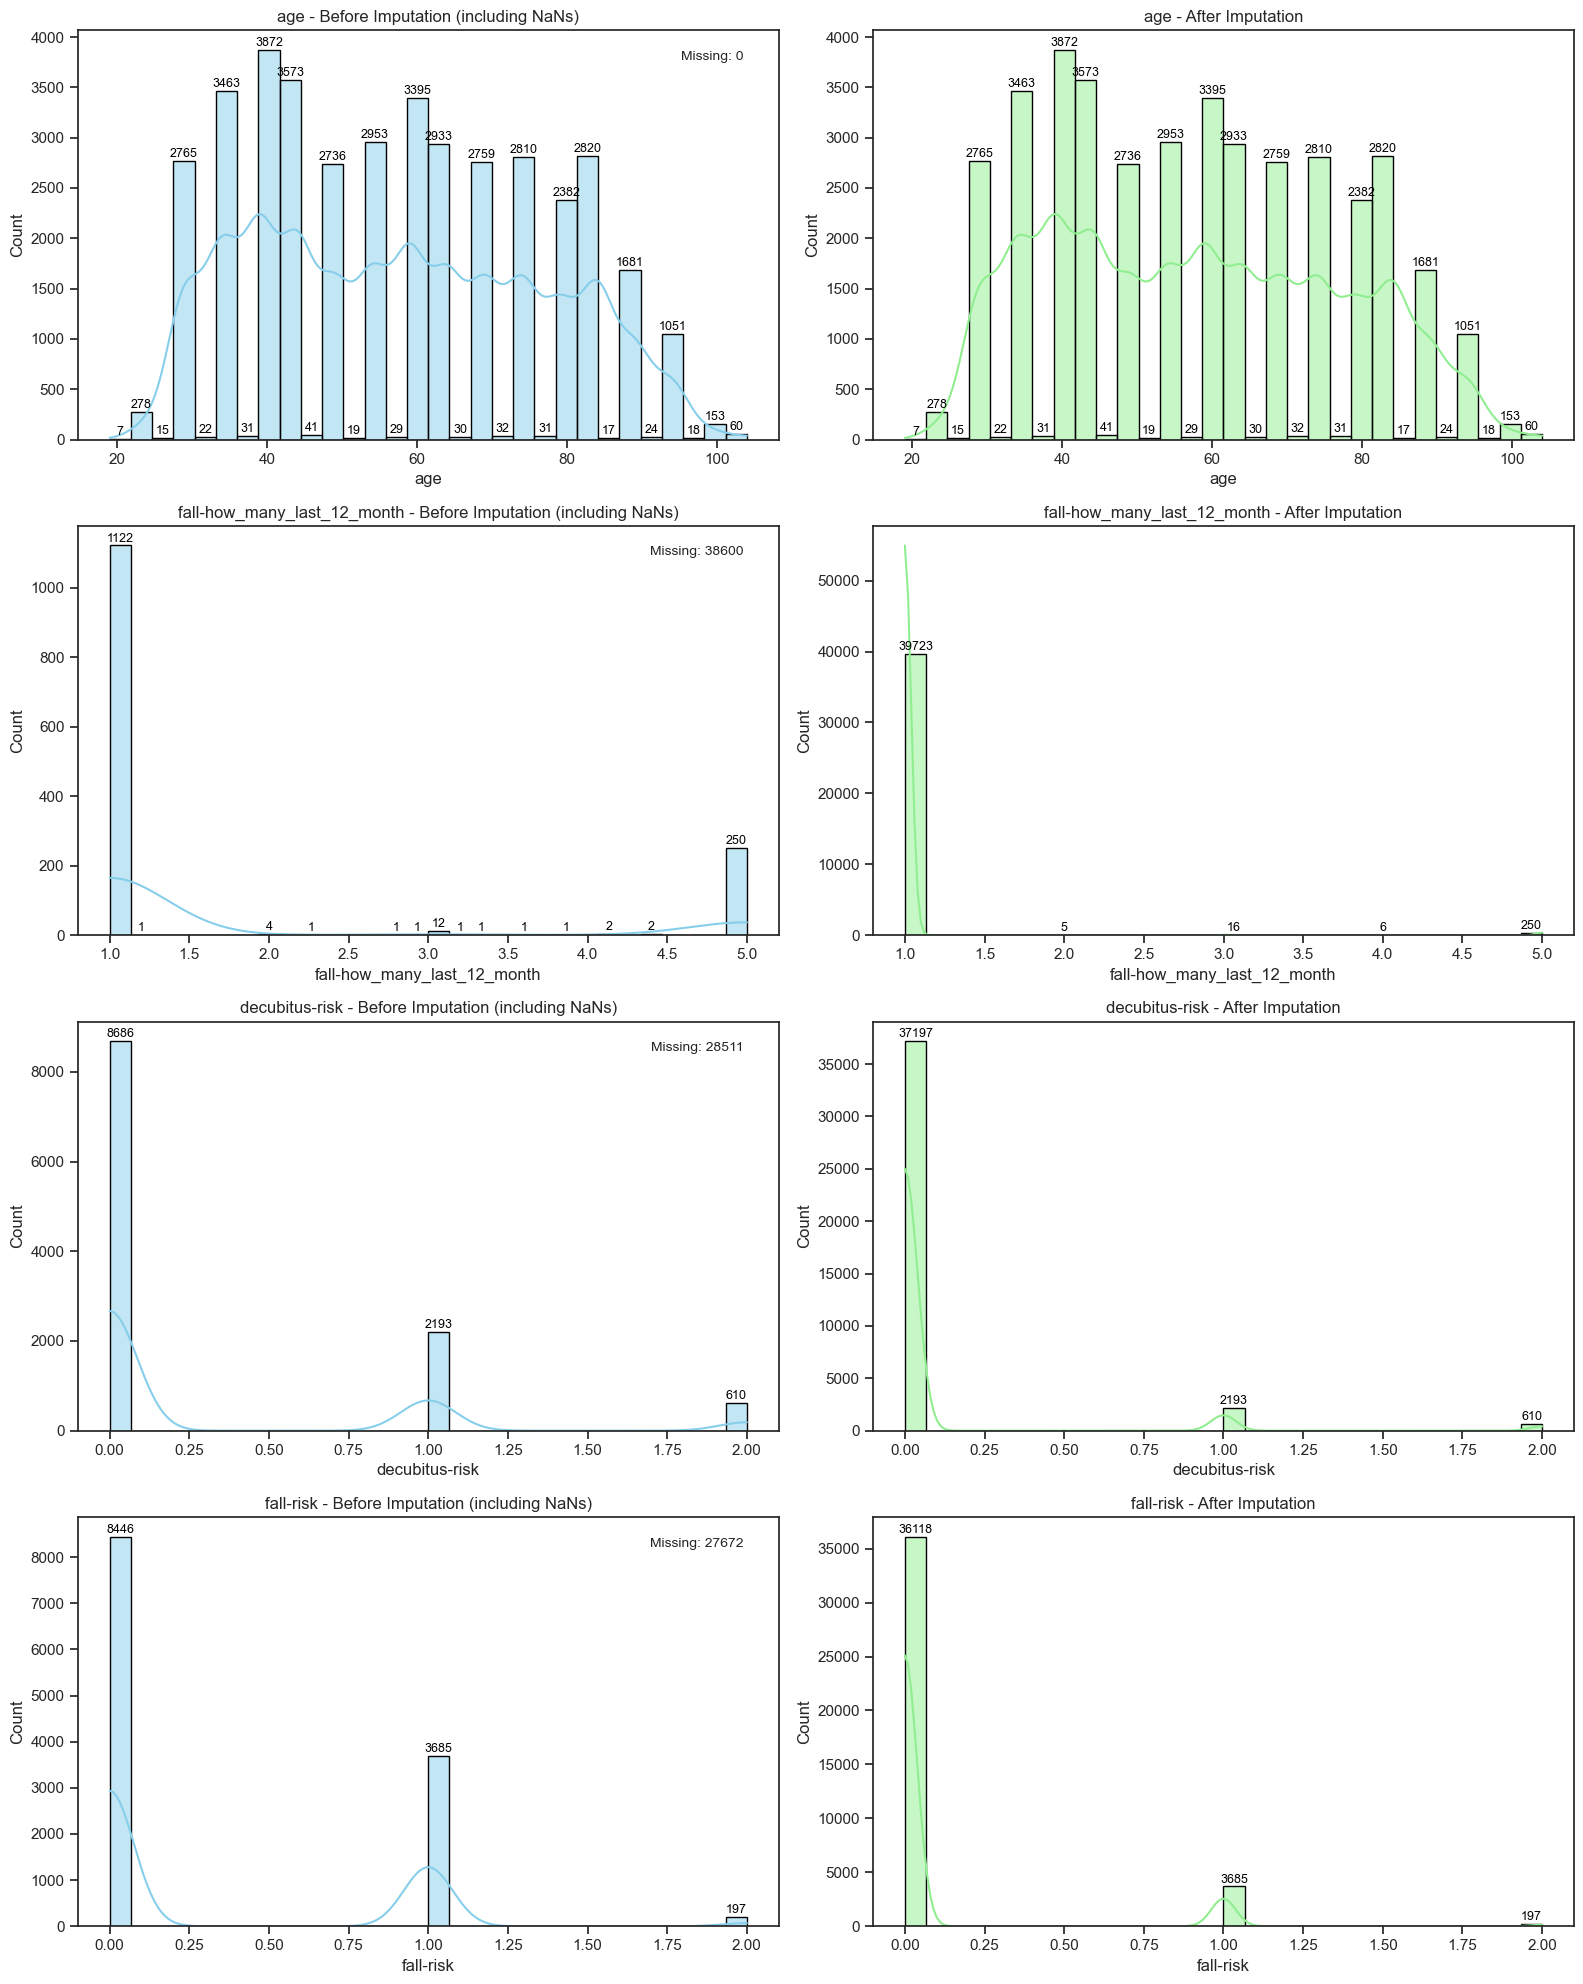

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set up the plot
plt.figure(figsize=(16, 5 * len(numerical_vars)))

for i, col in enumerate(numerical_vars):
	plt.subplot(len(numerical_vars), 2, 2 * i + 1)
	hist_before = sns.histplot(df_before[col], bins=30, kde=True, color="skyblue", edgecolor="black")
	plt.title(f'{col} - Before Imputation (including NaNs)')
	plt.xlabel(col)
	plt.ylabel('Count')

	# Annotate the bars with their respective counts
	for p in hist_before.patches:
		if p.get_height() > 0:  # Avoid annotating bars with zero height
			plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
						 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
						 textcoords='offset points')

	# Show number of missing values
	na_count = df_before[col].isna().sum()
	plt.annotate(f'Missing: {na_count}', xy=(0.95, 0.95), xycoords='axes fraction',
				 ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', fc='white'))

	plt.subplot(len(numerical_vars), 2, 2 * i + 2)
	hist_after = sns.histplot(df[col], bins=30, kde=True, color="lightgreen", edgecolor="black")
	plt.title(f'{col} - After Imputation')
	plt.xlabel(col)
	plt.ylabel('Count')

	# Annotate the bars with their respective counts
	for p in hist_after.patches:
		if p.get_height() > 0:  # Avoid annotating bars with zero height
			plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
						 ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
						 textcoords='offset points')

plt.tight_layout()
plt.show()


### CATEGORICAL VARIABLES

In [23]:
# Calculate the percentage of missing values for categorical variables
categorical_na_percentage = df[categorical_vars].isna().mean() * 100

# Print the result
print("Percentage of missing values for categorical variables:")
print(categorical_na_percentage)


Percentage of missing values for categorical variables:
procedure              0.0000
diagnosis              0.0000
bed_mobility-jones    93.9825
transfer              92.4850
walk-jones            89.0675
sex                    0.0000
dtype: float64


### 🧾 Handling Missing Values for Categorical & Bool Variables

We've got:

 ⚠️ High missingness in some categorical_vars and bool_vars

 ❓ Want to reduce dimensionality + interpret predictions

 ❌ One-hot encoding explodes feature count (3000+ cols) — bad for models like Logistic, SHAP



In [24]:
# Fill missing for categorical and bool variables with a placeholder string
for col in categorical_vars + bool_vars:
    # Convert to object type (non-nullable strings) and fill missing values
    df[col] = df[col].astype('object').fillna('missing')

# Print value distribution for categorical variables
print("Value distribution for categorical variables:")
for col in categorical_vars:
    print()
    print(df[col].value_counts())

# Print value distribution for boolean variables
print("\nValue distribution for boolean variables:")
for col in bool_vars:
    print()
    print(df[col].value_counts())

Value distribution for categorical variables:

procedure
0       17789
1-10     1198
1-20      620
1-22      396
3-84      332
3-90      308
1-24      307
3-82      300
3-99      279
3-80      278
3-76      270
5-02      264
5-01      240
1-26      236
9-98      232
5-03      232
9-70      225
9-61      215
3-75      202
9-60      196
1-27      194
1-31      189
9-64      185
5-04      180
5-05      178
9-41      177
9-50      176
9-28      165
9-32      163
5-06      158
1-33      156
3-73      155
9-40      153
9-20      150
5-09      145
9-26      142
1-42      140
5-07      135
8-98      134
8-92      134
1-41      130
8-93      120
8-81      120
8-97      119
8-80      118
1-40      118
5-08      117
8-91      117
1-43      115
8-83      111
3-72      111
8-63      111
5-11      110
8-82      109
8-60      108
5-10      108
8-70      108
3-70      107
8-64      104
8-85      103
1-47      101
8-77      100
8-53      100
8-90       98
8-55       97
5-13       97
8-71       96
5-23 

In [25]:
# Calculate the percentage of missing values for all columns
missing_percentage = (df.isna().sum() / len(df)) * 100

# Display the result
print("Percentage of NA values for all variables:")
print(missing_percentage.sort_values(ascending=False))

Percentage of NA values for all variables:
fallen                                              0.0
fall-last_12_month                                  0.0
fall-while_stay                                     0.0
fall-while_transfer                                 0.0
walk-impairment                                     0.0
walk-jones                                          0.0
walk-balance_and_gait_impaired                      0.0
walking_aid                                         0.0
excretions-impairment                               0.0
excretions-incontinence                             0.0
excretions-nykturie                                 0.0
cognition-impairment                                0.0
cognition-disoriented_time                          0.0
cognition-disoriented_location                      0.0
cognition-disoriented_own_person                    0.0
cognition-agitated                                  0.0
cognition-confused                                  0.0
psych

In [26]:
# # Correlation among numeric variables
# plt.figure(figsize=(8, 6))
# sns.heatmap(df[numerical_vars].corr(), annot=True, cmap='coolwarm')
# plt.title("Numeric Correlation Matrix")
# plt.show()

### 3. Outliers Detection

#### 3.1 Numerical Variables

In [27]:
def tukey_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

# Example for all numerical vars:
outlier_flags_tukey = pd.DataFrame()
for col in numerical_vars:
    outlier_flags_tukey[col] = tukey_outliers(df[col])

# Summary
print("Tukey Outliers Count:")
print(outlier_flags_tukey.sum().sort_values(ascending=False))



Tukey Outliers Count:
fall-risk                      3882
decubitus-risk                 2803
fall-how_many_last_12_month     277
age                               0
dtype: Int64


# Section 2: Data Exploration and Relationships

In this section we:
 - Analyze correlations and patterns within patient features. Determine whether combinations of variables tend to appear often together.

 - Utilize visualizations to present meaningful insights regarding patient fall risk. Explain which insights can be drawn from your plots.

 - Identify and create new features that may enhance predictive performance.

In [28]:
# # ========== Section 0: Correlation and Co-occurrence Patterns ==========

# from sklearn.feature_selection import mutual_info_classif
# from sklearn.preprocessing import LabelEncoder

# # Encode categorical and boolean variables numerically
# X_encoded = df[categorical_vars + bool_vars].apply(LabelEncoder().fit_transform)

# # Mutual information scores
# mi_scores = pd.Series(mutual_info_classif(X_encoded, y, discrete_features=True), index=X_encoded.columns)
# top_categorical_by_mi = mi_scores.sort_values(ascending=False).head(10)

# print("\n📊 Top 10 Categorical/Boolean Features by Mutual Information:")
# print(top_categorical_by_mi)

# # === Improved Co-occurrence Analysis ===
# # Use one-hot encoding for binary co-occurrence analysis
# df_ohe = pd.get_dummies(df[top_categorical_by_mi.index], drop_first=False, dtype=int)

# # Calculate co-occurrence matrix (dot product of binary matrix)
# co_matrix = df_ohe.T.dot(df_ohe)

# # Zero out diagonal (self-co-occurrence not useful)
# np.fill_diagonal(co_matrix.values, 0)

# # Unstack and sort
# cooccurrence_pairs = co_matrix.unstack().sort_values(ascending=False)
# cooccurrence_pairs = cooccurrence_pairs[cooccurrence_pairs > 0].drop_duplicates().head(10)

# # Convert to DataFrame
# cooccurrence_df = cooccurrence_pairs.reset_index()
# cooccurrence_df.columns = ['Feature 1', 'Feature 2', 'Count']

# print("\n🔗 Top Co-occurring Category Pairs (among MI Top 10):")
# print(cooccurrence_df)

# # Optional plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x="Count", y=cooccurrence_df.apply(lambda x: f"{x['Feature 1']} & {x['Feature 2']}", axis=1), data=cooccurrence_df)
# plt.title("Top Co-occurring Feature Pairs")
# plt.xlabel("Pairwise Count")
# plt.ylabel("Feature Pair")
# plt.tight_layout()
# plt.show()


## 2.2 Identify Top Features

In [29]:
# --- Config ---
NUM_COMPONENTS = 3
TOP_N_FEATURES = 20



📝 Human-readable PCA Labels:
pca1                      pca1 (fall-risk + decubitus-risk)
pca2    pca2 (fall-how_many_last_12_month + decubitus-risk)
pca3                            pca3 (age + decubitus-risk)
dtype: object

📝 Human-readable MCA Labels:
{'mca1': 'mca1 (diagnosis + procedure)', 'mca2': 'mca2 (diagnosis + procedure)', 'mca3': 'mca3 (diagnosis + bed_mobility-jones)'}

📋 Top PCA Variable Contributors (per component):

🔹 pca1:
fall-risk                      0.643973
decubitus-risk                 0.601670
age                            0.363628
fall-how_many_last_12_month    0.301771
Name: pca1, dtype: float64

🔹 pca2:
fall-how_many_last_12_month    0.939719
decubitus-risk                 0.311684
age                            0.110861
fall-risk                      0.086552
Name: pca2, dtype: float64

🔹 pca3:
age                            0.923194
decubitus-risk                 0.315116
fall-risk                      0.219465
fall-how_many_last_12_month    0.015819
Name:

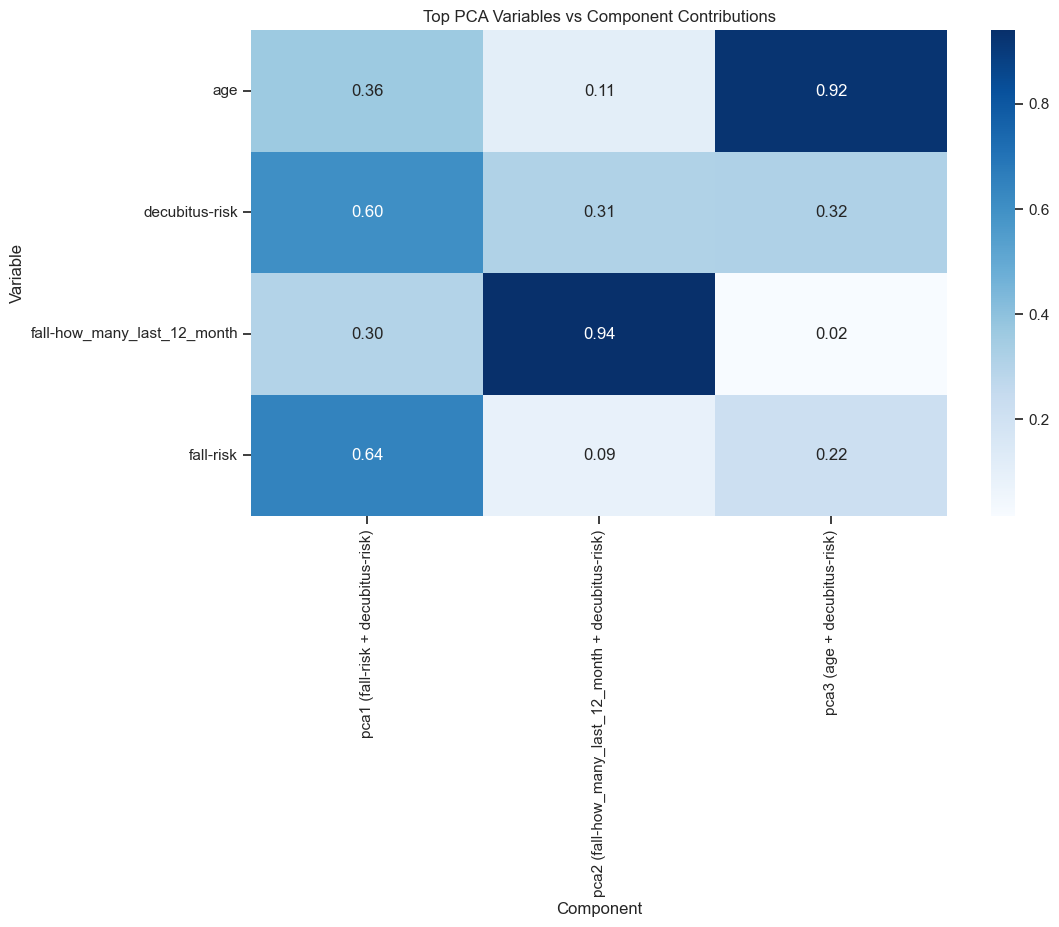

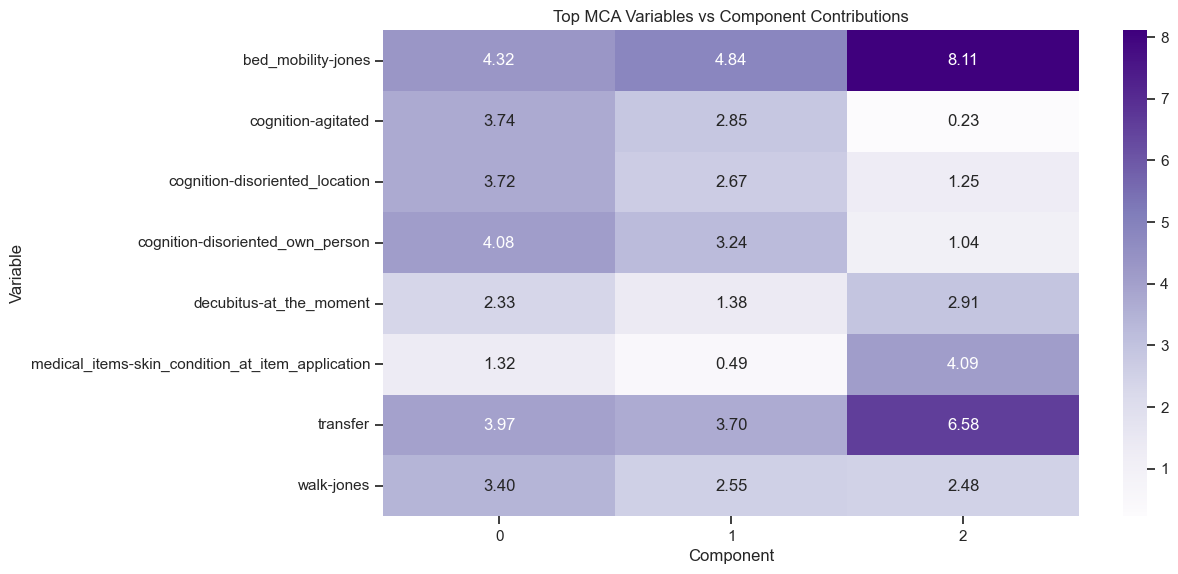


📝 Human-readable PCA Labels:
pca1 (fall-risk + decubitus-risk)                                                          pca1 (fall-risk + decubitus-risk) (fall-risk + decubitus-risk)
pca2 (fall-how_many_last_12_month + decubitus-risk)    pca2 (fall-how_many_last_12_month + decubitus-risk) (fall-how_many_last_12_month + decubitus-risk)
pca3 (age + decubitus-risk)                                                                            pca3 (age + decubitus-risk) (age + decubitus-risk)
dtype: object

⭐ Top Features by PCA/MCA Importance (Normalized):
age                                 1.000000
bed_mobility-jones                  1.000000
transfer                            0.824827
fall-how_many_last_12_month         0.686451
decubitus-risk                      0.622034
walk-jones                          0.487905
cognition-disoriented_own_person    0.484207
cognition-disoriented_location      0.442542
cognition-disoriented_time          0.416509
cognition-agitated                  0

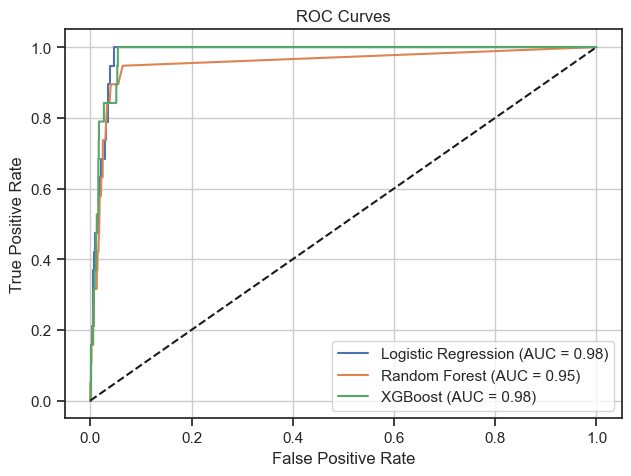

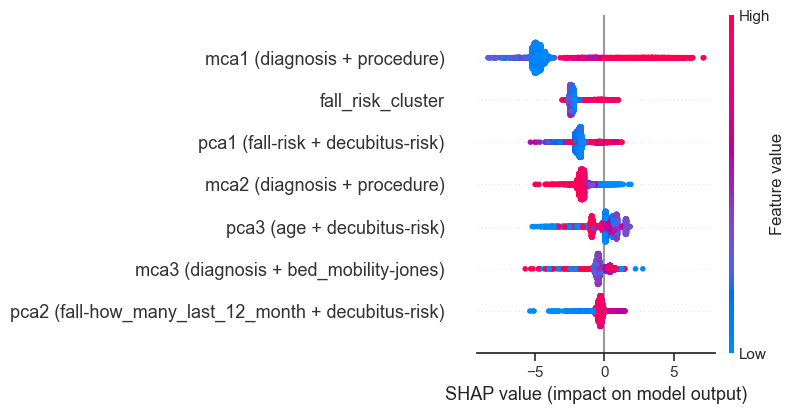


🔧 Best threshold for F1 (XGBoost): 0.20, F1 = 0.174


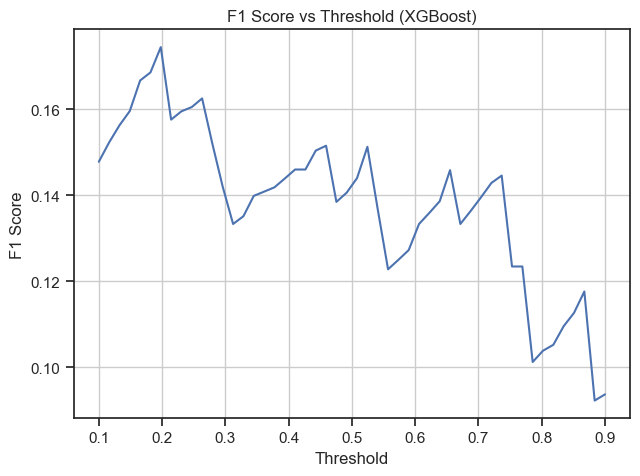

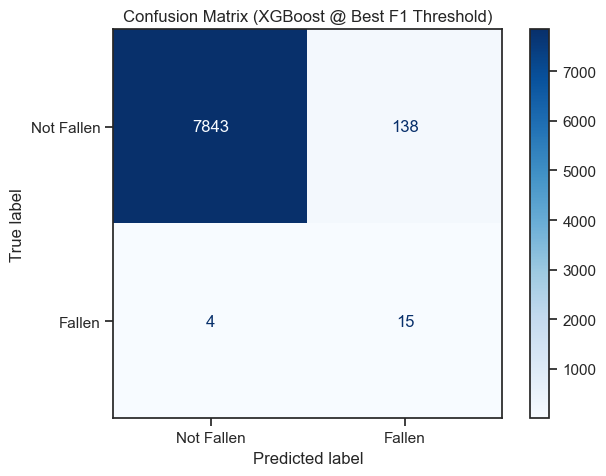


📋 Model Comparison Summary:
                     Accuracy  F1 Score   AUC 
Logistic Regression    0.950     0.086   0.983
Random Forest          0.989     0.117   0.954
XGBoost                0.986     0.142   0.982

🔍 Logistic Regression Coefficients:
mca2 (diagnosis + procedure)                          -3.222094
mca1 (diagnosis + procedure)                           2.447417
pca3 (age + decubitus-risk)                            1.002746
fall_risk_cluster                                      0.492718
pca1 (fall-risk + decubitus-risk)                      0.146327
pca2 (fall-how_many_last_12_month + decubitus-risk)   -0.144844
mca3 (diagnosis + bed_mobility-jones)                 -0.083551
dtype: float64

🌲 Random Forest Feature Importance:
fall_risk_cluster                                      0.295632
mca1 (diagnosis + procedure)                           0.267365
pca1 (fall-risk + decubitus-risk)                      0.157997
pca2 (fall-how_many_last_12_month + decubitus-risk)   

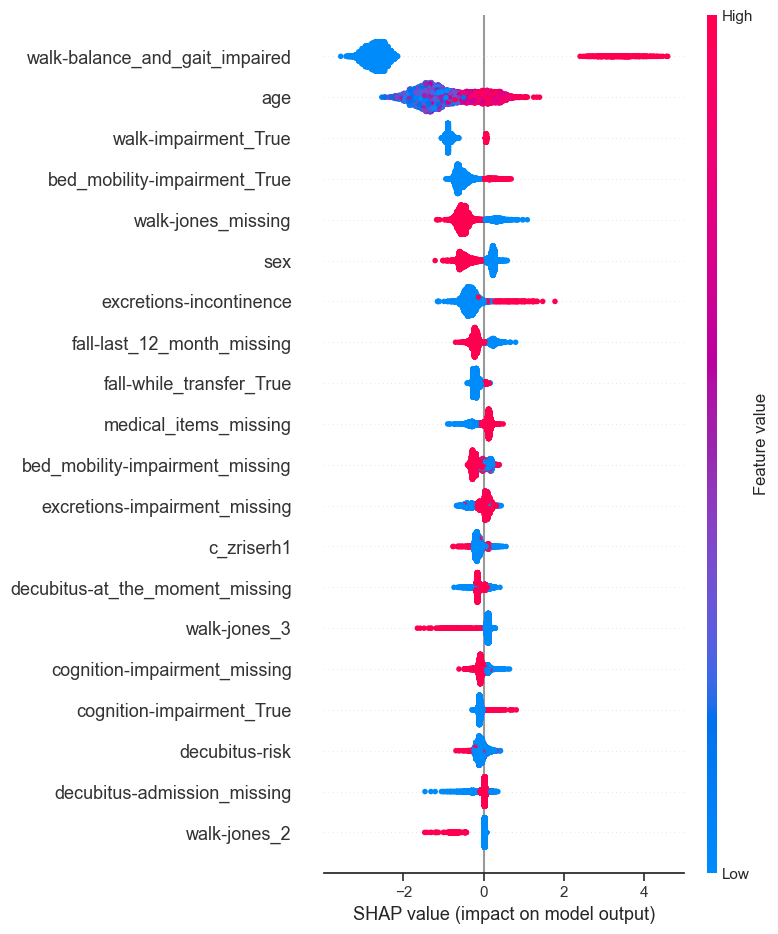

In [34]:


# 📦 Fall Prediction Pipeline


# ========== Section 2: Data Exploration and Relationships ==========

# Handle missing values
# for col in numerical_vars:
#     df[col] = df[col].fillna(df[col].mean())

# for col in categorical_vars + bool_vars:
#     df[col] = df[col].astype(str).fillna('missing')

# PCA on numerical data
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[numerical_vars])
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X_num_scaled), columns=[f'pca{i+1}' for i in range(3)])

# MCA on categorical + boolean data
X_cat = df[categorical_vars + bool_vars].copy()
mca = prince.MCA(n_components=3, random_state=42)
X_mca = mca.fit_transform(X_cat)
X_mca.columns = [f'mca{i+1}' for i in range(3)]

# Rename PCA/MCA columns for interpretability
pca_loadings = pd.DataFrame(np.abs(pca.components_.T), index=numerical_vars, columns=X_pca.columns)

def auto_label_pca_components(loadings, top_n=2):
    labels = {}
    for comp in loadings.columns:
        top_features = loadings[comp].abs().sort_values(ascending=False).head(top_n).index
        label = " + ".join(top_features)
        labels[comp] = f"{comp} ({label})"
    return pd.Series(labels)

pca_labels = auto_label_pca_components(pca_loadings)
pca_rename_map = {col: pca_labels[col] for col in X_pca.columns}
X_pca = X_pca.rename(columns=pca_rename_map)

mca_coords = mca.column_coordinates(X_cat).abs()
def extract_variable_name(colname):
    for original_col in X_cat.columns:
        if colname.startswith(original_col + '_') or colname == original_col:
            return original_col
    return colname

grouped_names = mca_coords.index.to_series().apply(extract_variable_name)
mca_grouped = mca_coords.groupby(grouped_names).sum()
mca_labels = {}
for i, comp in enumerate(mca_grouped.columns):
    top_vars = mca_grouped[comp].abs().sort_values(ascending=False).head(2).index.tolist()
    label = " + ".join(top_vars)
    mca_labels[f'mca{i+1}'] = f'mca{i+1} ({label})'
X_mca.columns = [mca_labels.get(f'mca{i+1}', f'mca{i+1}') for i in range(X_mca.shape[1])]

# Combine all components
X_combined = pd.concat([X_pca, X_mca], axis=1)
y = df['fallen']

# Select PCA and MCA columns dynamically
pca_cols = [c for c in X_combined.columns if c.startswith("pca")]
mca_cols = [c for c in X_combined.columns if c.startswith("mca")]

# Compute risk cluster weights and apply
pca_weights = pca.explained_variance_ratio_[:len(pca_cols)]
mca_weights = np.array([0.5, 0.3, 0.2])[:len(mca_cols)]  # Manual fallback weights

# Clean up for matrix multiplication
X_combined[pca_cols + mca_cols] = X_combined[pca_cols + mca_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Create fall_risk_cluster feature
df['fall_risk_cluster'] = X_combined[pca_cols].values @ pca_weights + X_combined[mca_cols].values @ mca_weights
X_combined['fall_risk_cluster'] = df['fall_risk_cluster']

print("\n📝 Human-readable PCA Labels:")
print(pca_labels)
print("\n📝 Human-readable MCA Labels:")
print(mca_labels)

# Visualize PCA/MCA variable contributions

# Top contributors per PCA component
top_n_pca = 5
pca_contrib = pca_loadings.copy()
top_pca_vars = pd.unique(
    np.concatenate(pca_contrib.apply(lambda col: col.abs().nlargest(top_n_pca).index.tolist()).values)
)
pca_contrib_top = pca_contrib.loc[sorted(top_pca_vars)]

# Top contributors per MCA component
top_n_mca = 5
mca_abs_coords = mca_coords.copy()
mca_contrib = mca_abs_coords.groupby(grouped_names).mean()
top_mca_vars = pd.unique(
    np.concatenate(mca_contrib.apply(lambda col: col.abs().nlargest(top_n_mca).index.tolist()).values)
)
mca_contrib_top = mca_contrib.loc[sorted(top_mca_vars)]

# Rename heatmap axes
pca_contrib_top.columns = [pca_labels.get(c, c) for c in pca_contrib_top.columns]
mca_contrib_top.columns = [mca_labels.get(c, c) for c in mca_contrib_top.columns]

print("\n📋 Top PCA Variable Contributors (per component):")
for comp in pca_contrib.columns:
    print(f"\n🔹 {comp}:")
    print(pca_contrib[comp].abs().sort_values(ascending=False).head(top_n_pca))

print("\n📋 Top MCA Variable Contributors (per component):")
for comp in mca_contrib.columns:
    print(f"\n🟣 {comp}:")
    print(mca_contrib[comp].abs().sort_values(ascending=False).head(top_n_mca))

# PCA Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pca_contrib_top, annot=True, fmt=".2f", cmap="Blues")
plt.title("Top PCA Variables vs Component Contributions")
plt.ylabel("Variable")
plt.xlabel("Component")
plt.show()

# MCA Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mca_contrib_top, annot=True, fmt=".2f", cmap="Purples")
plt.title("Top MCA Variables vs Component Contributions")
plt.ylabel("Variable")
plt.xlabel("Component")
plt.show()




# Feature contribution from PCA
pca_loadings = pd.DataFrame(np.abs(pca.components_.T), index=numerical_vars, columns=X_pca.columns)

def auto_label_pca_components(loadings, top_n=2):
    labels = {}
    for comp in loadings.columns:
        top_features = loadings[comp].abs().sort_values(ascending=False).head(top_n).index
        label = " + ".join(top_features)
        labels[comp] = f"{comp} ({label})"
    return pd.Series(labels)

pca_labels = auto_label_pca_components(pca_loadings)
print("\n📝 Human-readable PCA Labels:")
print(pca_labels)

# Feature contribution from MCA (absolute values of each dummy variable)
mca_coords = mca.column_coordinates(X_cat).abs()

# 🧠 Fix feature name extraction to preserve full names
def extract_variable_name(colname):
    for original_col in X_cat.columns:
        if colname.startswith(original_col + '_') or colname == original_col:
            return original_col
    return colname  # fallback

# Group dummy vars back to original variable names
grouped_names = mca_coords.index.to_series().apply(extract_variable_name)

# Sum contribution of dummy variables per component
mca_grouped = mca_coords.groupby(grouped_names).sum()

# Normalize per component instead of summing across all
category_counts = grouped_names.value_counts()
mca_importance_normalized = mca_grouped.div(category_counts, axis=0)
mca_importance = mca_importance_normalized.sum(axis=1)

# PCA importance
pca_importance = pca_loadings.sum(axis=1)

# Scale both for comparability
scaler = MinMaxScaler()
pca_scaled = pd.Series(
    scaler.fit_transform(pca_importance.values.reshape(-1, 1)).flatten(),
    index=pca_importance.index
)
mca_scaled = pd.Series(
    scaler.fit_transform(mca_importance.values.reshape(-1, 1)).flatten(),
    index=mca_importance.index
)

# Combine and rank
feature_scores = pd.concat([pca_scaled, mca_scaled]).sort_values(ascending=False)
top_features = feature_scores.head(10)

print("\n⭐ Top Features by PCA/MCA Importance (Normalized):")
print(top_features)



# ========== Section 3: Model Development ==========
# ========== Section 3: Model Development ==========

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

# Resample training data (SMOTE + undersampling)
over = SMOTE(sampling_strategy=0.2, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
resample_pipeline = Pipeline([('o', over), ('u', under)])

X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train, y_train)

print("\n📊 Resampled Training Set Class Distribution:")
print(pd.Series(y_train_resampled).value_counts())


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_resampled, y_train_resampled)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)


def show_metrics(model, X, y, name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    print(f"\n📊 {name} Performance:")
    print(f"Accuracy: {acc:.3f}, F1 Score: {f1:.3f}, AUC: {auc:.3f}")
    return acc, f1, auc, y_prob

metrics_summary = {}
for model, name in [(lr, "Logistic Regression"), (rf, "Random Forest"), (xgb, "XGBoost")]:
    acc, f1, auc, y_prob = show_metrics(model, X_test, y_test, name)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    metrics_summary[name] = {'Accuracy': acc, 'F1 Score': f1, 'AUC': auc}

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

explainer_xgb = shap.Explainer(xgb)
shap_values_xgb = explainer_xgb(X_test)
shap.summary_plot(shap_values_xgb, X_test)

thresholds = np.linspace(0.1, 0.9, 50)
xgb_probs = xgb.predict_proba(X_test)[:, 1]
f1s = [f1_score(y_test, xgb_probs > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1s)]
print(f"\n🔧 Best threshold for F1 (XGBoost): {best_thresh:.2f}, F1 = {max(f1s):.3f}")

plt.plot(thresholds, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold (XGBoost)")
plt.grid(True)
plt.show()

# ========== Section 4: Model Evaluation and Interpretation ==========

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
xgb_opt_preds = (xgb_probs > best_thresh).astype(int)
cm = confusion_matrix(y_test, xgb_opt_preds)
ConfusionMatrixDisplay(cm, display_labels=["Not Fallen", "Fallen"]).plot(cmap="Blues")
plt.title("Confusion Matrix (XGBoost @ Best F1 Threshold)")
plt.show()

summary_df = pd.DataFrame(metrics_summary).T
print("\n📋 Model Comparison Summary:")
print(summary_df.round(3))

print("\n🔍 Logistic Regression Coefficients:")
print(pd.Series(lr.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False).head(10))

print("\n🌲 Random Forest Feature Importance:")
print(pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10))

# Raw feature model

df_raw = df.copy()
df_encoded = pd.get_dummies(df_raw[numerical_vars + categorical_vars + bool_vars], drop_first=True)
X_raw = df_encoded
y_raw = df_raw['fallen']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, stratify=y_raw, test_size=0.2, random_state=42)

xgb_raw = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_raw.fit(X_train_raw, y_train_raw)

show_metrics(xgb_raw, X_test_raw, y_test_raw, "XGBoost (Raw Features)")

explainer_raw = shap.Explainer(xgb_raw)
shap_values_raw = explainer_raw(X_test_raw)
shap.summary_plot(shap_values_raw, X_test_raw)

# Comparison and Discussion Notes
# - Tradeoffs between interpretability and performance
# - Clinical utility of raw vs reduced features
# - Integration challenges in real-world healthcare settings


In [ ]:
print("\n📋 Top PCA Variable Contributors (per component):")
for comp in pca_contrib.columns:
    print(f"\n🔹 {comp}:")
    print(pca_contrib[comp].abs().sort_values(ascending=False).head(top_n_pca))


In [ ]:
print("\n📋 Top MCA Variable Contributors (per component):")
for comp in mca_contrib.columns:
    print(f"\n🟣 {comp}:")
    print(mca_contrib[comp].abs().sort_values(ascending=False).head(top_n_mca))



📋 Top PCA Variable Contributors (per component):

🔹 pca1:
fall-risk                      0.643973
decubitus-risk                 0.601670
age                            0.363628
fall-how_many_last_12_month    0.301771
Name: pca1, dtype: float64

🔹 pca2:
fall-how_many_last_12_month    0.939719
decubitus-risk                 0.311684
age                            0.110861
fall-risk                      0.086552
Name: pca2, dtype: float64

🔹 pca3:
age                            0.923194
decubitus-risk                 0.315116
fall-risk                      0.219465
fall-how_many_last_12_month    0.015819
Name: pca3, dtype: float64


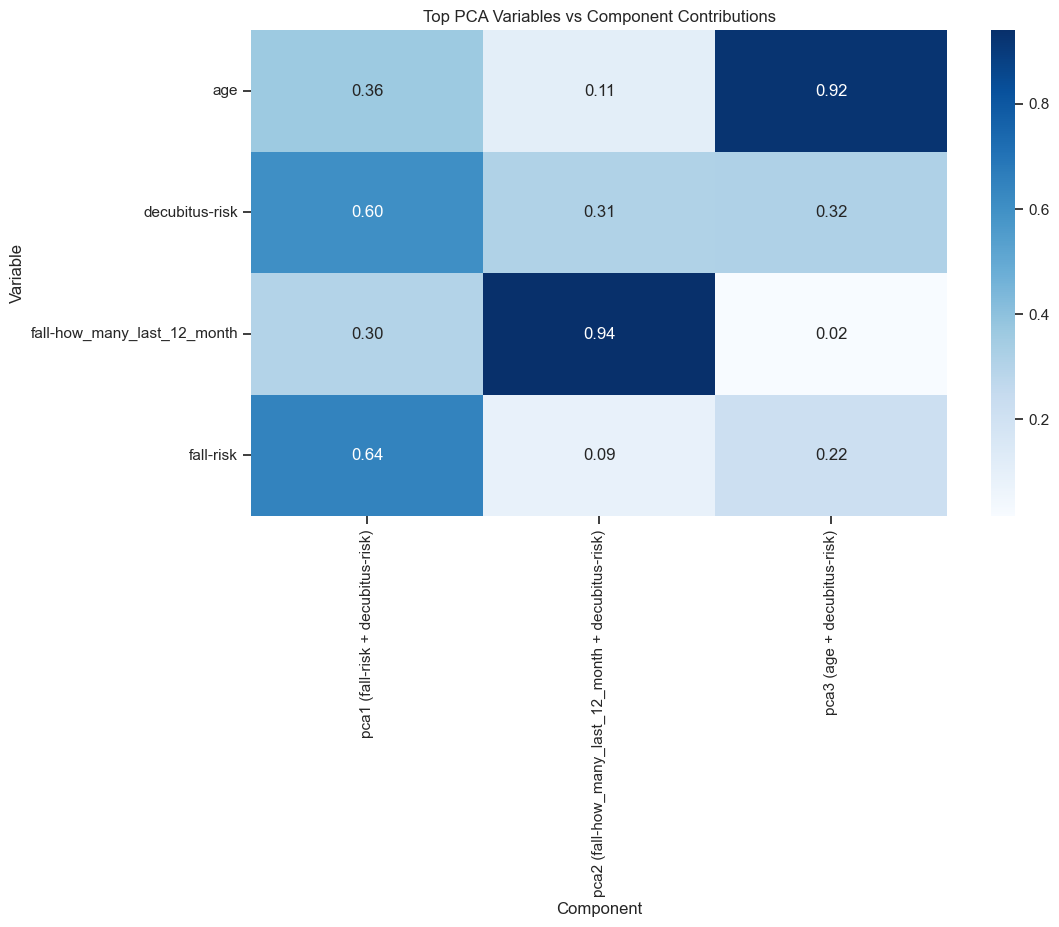


📋 Top MCA Variable Contributors (per component):

🟣 0:
bed_mobility-jones                  4.321610
cognition-disoriented_own_person    4.078847
transfer                            3.967904
cognition-agitated                  3.736619
cognition-disoriented_location      3.717450
Name: 0, dtype: float64

🟣 1:
bed_mobility-jones                  4.836362
transfer                            3.701730
cognition-disoriented_own_person    3.241660
cognition-agitated                  2.846224
cognition-disoriented_location      2.670914
Name: 1, dtype: float64

🟣 2:
bed_mobility-jones                                  8.112492
transfer                                            6.575508
medical_items-skin_condition_at_item_application    4.088087
decubitus-at_the_moment                             2.913344
walk-jones                                          2.477049
Name: 2, dtype: float64


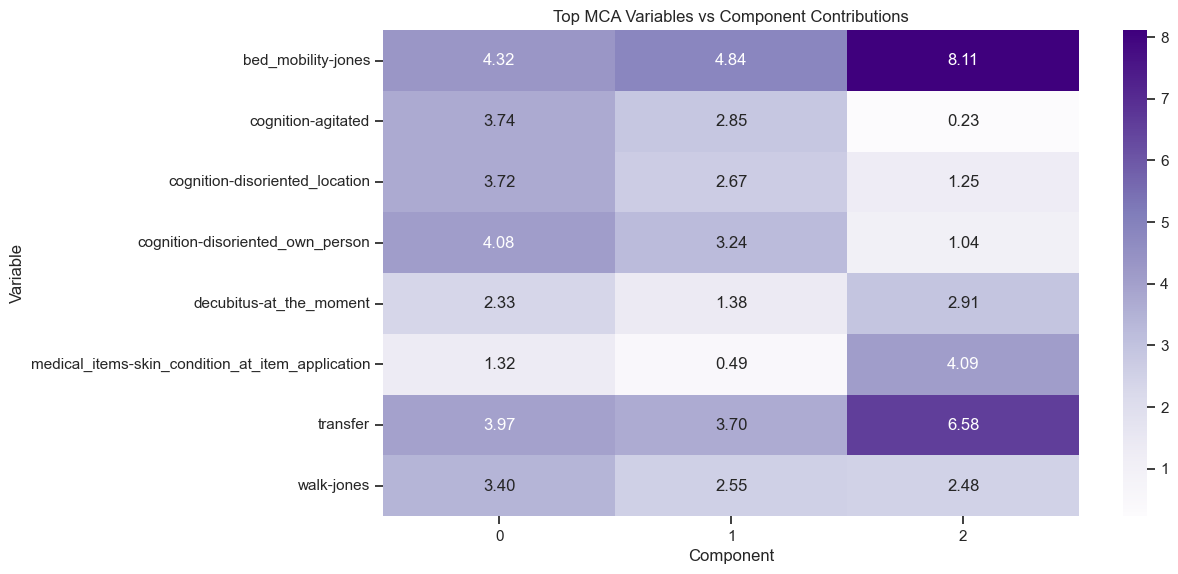

In [35]:
# -- Heatmap Section --

# Top PCA contributors table
print("\n📋 Top PCA Variable Contributors (per component):")
for comp in pca_contrib.columns:
    print(f"\n🔹 {comp}:")
    print(pca_contrib[comp].abs().sort_values(ascending=False).head(top_n_pca))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pca_contrib_top, annot=True, fmt=".2f", cmap="Blues")
plt.title("Top PCA Variables vs Component Contributions")
plt.ylabel("Variable")
plt.xlabel("Component")
plt.show()

# Top MCA contributors table
print("\n📋 Top MCA Variable Contributors (per component):")
for comp in mca_contrib.columns:
    print(f"\n🟣 {comp}:")
    print(mca_contrib[comp].abs().sort_values(ascending=False).head(top_n_mca))

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mca_contrib_top, annot=True, fmt=".2f", cmap="Purples")
plt.title("Top MCA Variables vs Component Contributions")
plt.ylabel("Variable")
plt.xlabel("Component")
plt.show()


In [36]:
# ========== Section 6: Patient Segmentation via Clustering ==========

from sklearn.cluster import KMeans

# Select components for clustering (already renamed in Section 2)
X_cluster = X_combined[[*pca_cols, *mca_cols]]

# Run KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['patient_segment'] = kmeans.fit_predict(X_cluster)

# Human-readable segment labels (you can refine based on PCA/MCA heatmaps)
# Based on PCA/MCA component inspection
# You may need to adjust this mapping after checking cluster centroids
segment_labels = {
    0: 'Clinical Complexity Risk',       # likely age/fall/decubitus
    1: 'Cognitive-Impairment Risk',      # confusion, disorientation
    2: 'Mobility-Impairment Risk',       # bed mobility, transfer
    3: 'Mixed/Low Risk'                  # otherwise
}

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_cluster.columns)
print("\n🔍 Cluster Centers (for manual verification):")
print(centroids.round(2))

df['patient_segment_label'] = df['patient_segment'].map(segment_labels)

print("\n📊 Patient Segment Distribution:")
print(df['patient_segment_label'].value_counts())


# ========== Section 7: Smart Clinical Flags ==========

# Flag 1: Missing fall history + mobility issues
flag_mobility = (
    (df['fall-how_many_last_12_month'] == 0) |
    (df['fall-how_many_last_12_month'].astype(str).str.lower().isin(['nan', 'missing']))
) & (
    df['bed_mobility-jones'].astype(str).str.lower().str.contains('severely|bedfast|immobile', na=False)
)
df['flag_missing_fall_and_mobility'] = flag_mobility

# Flag 2: Age > 85 + confusion/disorientation
flag_cognitive = (
    df['age'] > 85
) & (
    df['cognition-confused'].astype(str) == 'True'
)
df['flag_elderly_confused'] = flag_cognitive

# Flag 3: Highest composite risk
top_5_percentile = df['fall_risk_cluster'].quantile(0.95)
df['flag_highest_risk'] = df['fall_risk_cluster'] >= top_5_percentile

print("\n⚠️ Smart Risk Flags:")
print(f"\n🟡 Patients with Missing Fall History + Mobility Impairment: {df['flag_missing_fall_and_mobility'].sum()}")
print(f"🔴 Elderly Patients with Cognitive Confusion: {df['flag_elderly_confused'].sum()}")
print(f"🟠 Highest Composite Risk Patients: {df['flag_highest_risk'].sum()}")


# ========== Section 8: Fall Rate by Segment and Risk Level ==========

# Re-bin fall risk level using observed fall rate
bins = [-np.inf, df['fall_risk_cluster'].quantile(0.8), df['fall_risk_cluster'].quantile(0.95), np.inf]
labels = ['Low', 'Medium', 'High']
df['fall_risk_level'] = pd.cut(df['fall_risk_cluster'], bins=bins, labels=labels)

print("\n📊 Fall Risk Level Distribution:")
print(df['fall_risk_level'].value_counts())

# Fall rate by level
fall_rate_by_level = df.groupby('fall_risk_level')['fallen'].mean().apply(lambda x: f"{x*100:.2f}%")
print("\n📊 Fall Rate per Fall Risk Level:")
print(fall_rate_by_level)

# Fall rate by patient segment
fall_rate_by_segment = df.groupby('patient_segment_label')['fallen'].mean().apply(lambda x: f"{x*100:.2f}%")
print("\n📊 Fall Rate per Patient Segment:")
print(fall_rate_by_segment)


# ========== Section 9: Segment-Based Intervention Suggestions ==========

print("\n💡 Suggested Interventions by Patient Segment:\n")

segment_interventions = {
    "Mobility-Impairment Risk": [
        "- Perform mobility assessments (e.g., Timed Up and Go)",
        "- Assign physiotherapy or mobility aids (e.g., walkers, bed rails)",
        "- Review transfer protocols with nursing staff"
    ],
    "Cognitive-Impairment Risk": [
        "- Initiate confusion assessment protocol (e.g., CAM)",
        "- Use fall-prevention signage or bedside alarms",
        "- Monitor frequently and reduce nighttime disruptions"
    ],
    "Clinical Complexity Risk": [
        "- Skin integrity checks and repositioning schedule",
        "- Evaluate for comorbidities affecting fall risk",
        "- Coordinate with multidisciplinary team (nurse, geriatrician, pharmacist)"
    ],
    "Mixed/Low Risk": [
        "- Maintain standard fall precautions",
        "- Educate on call bell usage",
        "- Continue routine monitoring"
    ]
}

for segment, actions in segment_interventions.items():
    print(f"🔹 {segment}:")
    for a in actions:
        print(f"   {a}")
    print()



🔍 Cluster Centers (for manual verification):
   pca1 (fall-risk + decubitus-risk)  \
0               -0.66                  
1                4.04                  
2                6.50                  
3                0.05                  

   pca2 (fall-how_many_last_12_month + decubitus-risk)  \
0                          0.12                          
1                         -1.41                          
2                         10.56                          
3                         -0.09                          

   pca3 (age + decubitus-risk)  mca1 (diagnosis + procedure)  \
0            -0.67                         -0.11               
1            -0.94                          1.26               
2            -0.17                          1.06               
3             0.85                         -0.07               

   mca2 (diagnosis + procedure)  mca3 (diagnosis + bed_mobility-jones)  
0              0.04                             -0.00               

🔍 Patient Segment Distribution
Segment	Count	Interpretation
Mobility-Impairment Risk	19,214	Most patients have physical limitations (bed/walk/transfer) but not necessarily cognitive decline.
Clinical Complexity Risk	18,010	Likely older patients with skin issues, comorbidities, fall history, etc.
Mixed/Low Risk	2,505	Patients with low/no significant risk across main axes.
Cognitive-Impairment Risk	271	A very specific and high-risk but rare group with strong cognitive issues (disoriented/confused).

✅ This distribution is reasonable. Cognitive issues are often rare but severe. Mixed/low risk is small due to your data being from a hospital population, where most patients have some risk.


🧠 Insights to Present
To Hospital Director:

“We’ve segmented patients into 4 clear risk groups — and we now know which are most vulnerable.”

“Only 271 patients are high cognitive-risk, but they account for 4.8% fall rate.”

“We identified the 2,000 highest-risk patients — allowing for targeted interventions.”

To Clinical Staff:

“Here are 103 elderly confused patients — we recommend focused monitoring.”

“Patients with mobility limitations but no fall history: consider fall risk assessment tools.”

# Section 2: Data Exploration & Relationships

#### DIMENSIONALITY REDUCTION USING FAMD (Factor Analysis of Mixed Data)

Why: Our data is a mix of numerical, categorical, and binary.

FAMD combines:
- PCA for numerical features
- MCA for categorical features

It treats all variable types appropriately and returns components that represent all of them.


In [37]:
# ========== Segment-Specific Intervention Recommendations ==========

print("\n💡 Suggested Interventions by Patient Segment:\n")

segment_interventions = {
    "Mobility-Impairment Risk": [
        "- Perform mobility assessments (e.g., Timed Up and Go)",
        "- Assign physiotherapy or mobility aids (e.g., walkers, bed rails)",
        "- Review transfer protocols with nursing staff"
    ],
    "Cognitive-Impairment Risk": [
        "- Initiate confusion assessment protocol (e.g., CAM)",
        "- Use fall-prevention signage or bedside alarms",
        "- Monitor frequently and reduce nighttime disruptions"
    ],
    "Clinical Complexity Risk": [
        "- Skin integrity checks and repositioning schedule",
        "- Evaluate for comorbidities affecting fall risk (e.g., neuropathy, sedation)",
        "- Coordinate with multidisciplinary team (nurse, geriatrician, pharmacist)"
    ],
    "Mixed/Low Risk": [
        "- Maintain standard fall precautions",
        "- Educate on call bell usage and staff availability",
        "- Continue routine monitoring and reassessment"
    ]
}

# Print nicely
for segment, actions in segment_interventions.items():
    print(f"🔹 {segment}:")
    for a in actions:
        print(f"   {a}")
    print()



💡 Suggested Interventions by Patient Segment:

🔹 Mobility-Impairment Risk:
   - Perform mobility assessments (e.g., Timed Up and Go)
   - Assign physiotherapy or mobility aids (e.g., walkers, bed rails)
   - Review transfer protocols with nursing staff

🔹 Cognitive-Impairment Risk:
   - Initiate confusion assessment protocol (e.g., CAM)
   - Use fall-prevention signage or bedside alarms
   - Monitor frequently and reduce nighttime disruptions

🔹 Clinical Complexity Risk:
   - Skin integrity checks and repositioning schedule
   - Evaluate for comorbidities affecting fall risk (e.g., neuropathy, sedation)
   - Coordinate with multidisciplinary team (nurse, geriatrician, pharmacist)

🔹 Mixed/Low Risk:
   - Maintain standard fall precautions
   - Educate on call bell usage and staff availability
   - Continue routine monitoring and reassessment




📜 Human-readable PCA Labels:
pca1                      pca1 (fall-risk + decubitus-risk)
pca2    pca2 (fall-how_many_last_12_month + decubitus-risk)
pca3                            pca3 (age + decubitus-risk)
dtype: object

📜 Human-readable MCA Labels:
{'mca1': 'mca1 (bed_mobility-jones + transfer)', 'mca2': 'mca2 (bed_mobility-jones + transfer)', 'mca3': 'mca3 (bed_mobility-jones + transfer)'}

⭐ Top Features by PCA/MCA Importance (Normalized):
age                                 1.000000
bed_mobility-jones                  1.000000
transfer                            0.814009
fall-how_many_last_12_month         0.686451
decubitus-risk                      0.622034
walk-jones                          0.471877
cognition-disoriented_own_person    0.471412
cognition-disoriented_location      0.430636
cognition-disoriented_time          0.405503
cognition-agitated                  0.381701
dtype: float64

✅ After SMOTE:
X_train_balanced shape: (63848, 7)
y_train_balanced:
 fallen
False  

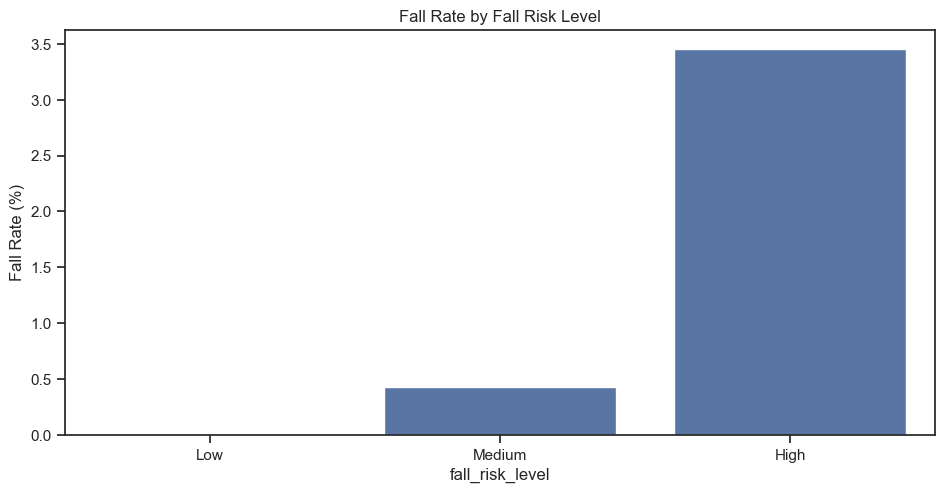

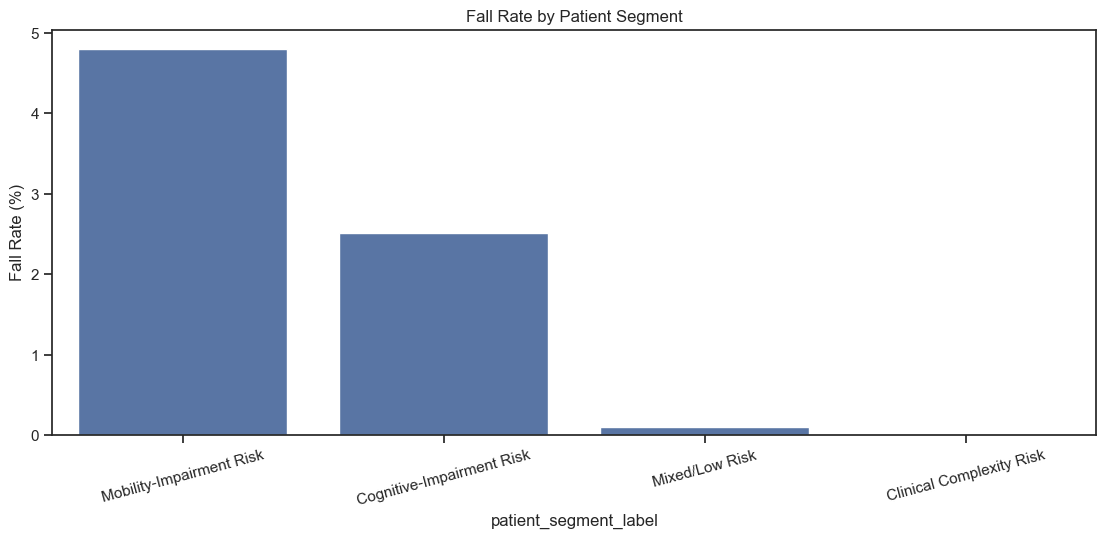


📊 Patient Segment Distribution:
patient_segment_label
Mobility-Impairment Risk     19135
Cognitive-Impairment Risk    18008
Clinical Complexity Risk      2586
Mixed/Low Risk                 271
Name: count, dtype: int64

⚠️ Smart Risk Flags:

🟡 Patients with Missing Fall History + Mobility Impairment: 0
🔴 Elderly Patients with Cognitive Confusion: 103
🟠 Highest Composite Risk Patients: 2000


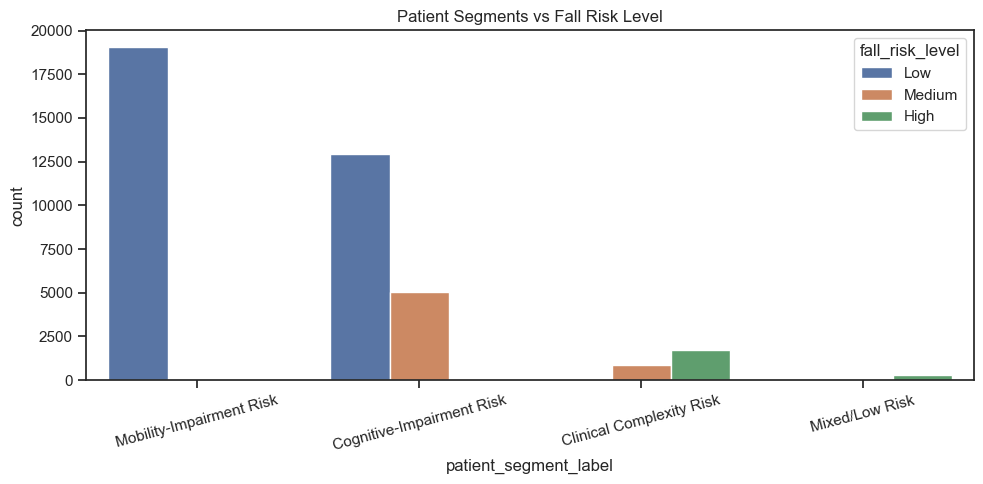

In [38]:
# 📦 Fall Prediction Pipeline (Structured for Jupyter Notebook)

# ========== Section 2: Data Exploration and Relationships ==========

# Handle missing values
for col in numerical_vars:
    df[col] = df[col].fillna(df[col].mean())

for col in categorical_vars + bool_vars:
    df[col] = df[col].astype(str).fillna('missing')

# PCA on numerical data
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(df[numerical_vars])
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X_num_scaled), columns=[f'pca{i+1}' for i in range(3)])

# ✂️ Remove high-cardinality vars from MCA (but keep them for modeling)
excluded_from_mca = ['diagnosis', 'procedure']
mca_vars_filtered = [col for col in categorical_vars + bool_vars if col not in excluded_from_mca]

X_cat = df[mca_vars_filtered].copy()
for col in X_cat.columns:
    X_cat[col] = X_cat[col].astype(str).fillna('missing')

# 🎯 Apply MCA on filtered variables
mca = prince.MCA(n_components=3, random_state=42)
X_mca = mca.fit_transform(X_cat)
X_mca.columns = [f'mca{i+1}' for i in range(3)]

# Rename PCA/MCA columns for interpretability
pca_loadings = pd.DataFrame(np.abs(pca.components_.T), index=numerical_vars, columns=X_pca.columns)

def auto_label_pca_components(loadings, top_n=2):
    labels = {}
    for comp in loadings.columns:
        top_features = loadings[comp].abs().sort_values(ascending=False).head(top_n).index
        label = " + ".join(top_features)
        labels[comp] = f"{comp} ({label})"
    return pd.Series(labels)

pca_labels = auto_label_pca_components(pca_loadings)
pca_rename_map = {col: pca_labels[col] for col in X_pca.columns}
X_pca = X_pca.rename(columns=pca_rename_map)

# Feature contribution from MCA (absolute values of each dummy variable)
mca_coords = mca.column_coordinates(X_cat).abs()

def extract_variable_name(colname):
    for original_col in X_cat.columns:
        if colname.startswith(original_col + '_') or colname == original_col:
            return original_col
    return colname

grouped_names = mca_coords.index.to_series().apply(extract_variable_name)
mca_grouped = mca_coords.groupby(grouped_names).sum()
mca_labels = {}
for i, comp in enumerate(mca_grouped.columns):
    top_vars = mca_grouped[comp].abs().sort_values(ascending=False).head(2).index.tolist()
    label = " + ".join(top_vars)
    mca_labels[f'mca{i+1}'] = f"mca{i+1} ({label})"
X_mca.columns = [mca_labels.get(f'mca{i+1}', f'mca{i+1}') for i in range(X_mca.shape[1])]

# Combine all components
X_combined = pd.concat([X_pca, X_mca], axis=1)
y = df['fallen']

# Select PCA and MCA columns dynamically
pca_cols = [c for c in X_combined.columns if c.startswith("pca")]
mca_cols = [c for c in X_combined.columns if c.startswith("mca")]

# Compute risk cluster weights and apply
pca_weights = pca.explained_variance_ratio_[:len(pca_cols)]
mca_weights = np.array([0.5, 0.3, 0.2])[:len(mca_cols)]  # Manual fallback weights

# Clean up for matrix multiplication
X_combined[pca_cols + mca_cols] = X_combined[pca_cols + mca_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Create fall_risk_cluster feature
df['fall_risk_cluster'] = X_combined[pca_cols].values @ pca_weights + X_combined[mca_cols].values @ mca_weights
X_combined['fall_risk_cluster'] = df['fall_risk_cluster']

print("\n📜 Human-readable PCA Labels:")
print(pca_labels)
print("\n📜 Human-readable MCA Labels:")
print(mca_labels)

# Normalize PCA and MCA feature importance for unified comparison
category_counts = grouped_names.value_counts()
mca_importance_normalized = mca_grouped.div(category_counts, axis=0)
mca_importance = mca_importance_normalized.sum(axis=1)
pca_importance = pca_loadings.sum(axis=1)

scaler = MinMaxScaler()
pca_scaled = pd.Series(scaler.fit_transform(pca_importance.values.reshape(-1, 1)).flatten(), index=pca_importance.index)
mca_scaled = pd.Series(scaler.fit_transform(mca_importance.values.reshape(-1, 1)).flatten(), index=mca_importance.index)

feature_scores = pd.concat([pca_scaled, mca_scaled]).sort_values(ascending=False)
top_features = feature_scores.head(10)
print("\n⭐ Top Features by PCA/MCA Importance (Normalized):")
print(top_features)

# ========== Section 2.5: Resampling for Imbalanced Data ==========

from imblearn.over_sampling import SMOTE

# Split before resampling
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the minority class
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n✅ After SMOTE:")
print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced:\n", pd.Series(y_train_balanced).value_counts())

# 🌟 Re-train models here using X_train_balanced and y_train_balanced

# 🌟 Evaluate using the original imbalanced X_test and y_test to simulate real-world performance

# ======== Section 3: Feature Engineering and Risk Scoring ========

# 🎯 Create a "fall_risk_cluster" based on top PCA/MCA dimensions
# (already computed above)

# === Re-bin fall risk using clinically relevant cluster score thresholds ===
low_thresh = df['fall_risk_cluster'].quantile(0.8)
med_thresh = df['fall_risk_cluster'].quantile(0.95)

df['fall_risk_level'] = pd.cut(
    df['fall_risk_cluster'],
    bins=[-float('inf'), low_thresh, med_thresh, float('inf')],
    labels=['Low', 'Medium', 'High']
)
print("\n📊 Fall Risk Level Distribution:")
print(df['fall_risk_level'].value_counts())

# === Fall rate per risk level ===
fall_rates = df.groupby('fall_risk_level')['fallen'].mean().sort_index() * 100
print("\n📊 Fall Rate per Fall Risk Level:")
print(fall_rates.round(2).astype(str) + '%')

# === Fall rate per patient segment ===
segment_rates = df.groupby('patient_segment_label')['fallen'].mean().sort_values(ascending=False) * 100
print("\n📊 Fall Rate per Patient Segment:")
print(segment_rates.round(2).astype(str) + '%')

# Optional Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=fall_rates.index, y=fall_rates.values)
plt.ylabel("Fall Rate (%)")
plt.title("Fall Rate by Fall Risk Level")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=segment_rates.index, y=segment_rates.values)
plt.ylabel("Fall Rate (%)")
plt.title("Fall Rate by Patient Segment")
plt.xticks(rotation=15)
plt.show()

# ========== Section 5: Advanced Patient Segmentation & Smart Flags ==========

from sklearn.cluster import KMeans

# 🎯 Cluster patients using PCA + MCA components
X_cluster = X_combined.copy()
kmeans = KMeans(n_clusters=4, random_state=42)
df['patient_segment'] = kmeans.fit_predict(X_cluster)

# Map segments to interpretability labels manually (can be refined)
segment_labels = {
    0: 'Mobility-Impairment Risk',
    1: 'Cognitive-Impairment Risk',
    2: 'Clinical Complexity Risk',
    3: 'Mixed/Low Risk'
}
df['patient_segment_label'] = df['patient_segment'].map(segment_labels)
print("\n📊 Patient Segment Distribution:")
print(df['patient_segment_label'].value_counts())

# 🎯 Smart Flags
print("\n⚠️ Smart Risk Flags:")
df['flag_fall_missing_and_mobility'] = (
    (df['fall-how_many_last_12_month'].astype(str) == 'missing') &
    (
        (df['bed_mobility-jones'].astype(str).str.contains('impaired|missing', case=False, na=False)) |
        (df['walk-jones'].astype(str).str.contains('impaired|missing', case=False, na=False)) |
        (df['transfer'].astype(str).str.contains('impaired|missing', case=False, na=False))
    )
)

df['flag_elderly_confused'] = (
    (df['age'] > 85) &
    (df['cognition-confused'].astype(str) == 'True')
)

# ✨ Expand: Flag patients with high PCA1 + MCA1 (composite cluster score)
df['flag_high_combined_score'] = (df['fall_risk_cluster'] > df['fall_risk_cluster'].quantile(0.95))

# Flag summaries
print("\n🟡 Patients with Missing Fall History + Mobility Impairment:", df['flag_fall_missing_and_mobility'].sum())
print("🔴 Elderly Patients with Cognitive Confusion:", df['flag_elderly_confused'].sum())
print("🟠 Highest Composite Risk Patients:", df['flag_high_combined_score'].sum())

# Optional Visualization
plt.figure(figsize=(10, 5))
sns.countplot(x='patient_segment_label', hue='fall_risk_level', data=df)
plt.title("Patient Segments vs Fall Risk Level")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Correlation analytics
- Heatmap
- Rule mining: Attecendent -> Consequence



## Visualization of meaningful insights
- Plotting age group -> Fall (depends on the previous result)

## Feature engineering
- Summarize various features/columns that are connected to each other -> Possibly stronger prediction

# Section 3: Model Development

## Logistic Regression (simple model)

## Neural Network (complex model)

# Section 4: Model Evaluation & Interpretation

## Strength & Weakness
- Parameters that influence the prediction result

## Stakeholder etc.
- Which model is preferable in which scenario/for which stakeholder


## Actionable insights